In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Import data
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 25
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'ie_deblur_ls_resolvent_patch'

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.weight.requires_grad = False;

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.weight.requires_grad = False;
blur_gpu.to(device);

# Generate winsplit
split = modules.AdjointSequential(
    modules.AdjointPatchSplitter((4,4), (8,8)),
    modules.AdjointFlatten(-2, -1, (4,4))
)

In [5]:
# Initialize dimensions, models, parameters and optimizers

patch_dims = [64, 64, 64]
grid_dims =  [16, 16, 16]

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
}

nets = {
    "IRE": models.dense.AdjointDenseMixer(
        patch_dims,
        grid_dims,
        diagonal=False,
        resolvent=True,
        lmbd=0.5,
        iter=16,
        **model_kwargs,
    ),
    "IRED": models.dense.AdjointDenseMixer(
        patch_dims,
        grid_dims,
        diagonal=True,
        resolvent=True,
        lmbd=0.5,
        iter=16,
        **model_kwargs,
    ),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)
    

In [6]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}
    
    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    kwargs = {'reduction': reduction, 'alpha': 6.0}
    
    losses['lx'] = utils.loss.logcosh(xh, x, **kwargs)
    losses['ly'] = utils.loss.logcosh(yh, y, **kwargs)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params IRE     :  10752
No. params IRED    :  10832


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k][0] for k in sample_indices_small])
xs = split(xims).to(device)
ys = split(blur(xims[:,None,...])[:,0,...]).to(device)

xt = torch.cat([test[k][0] for k in range(len(test))])
yt = split(blur(xt[:,None,...])[:,0,...]).to(device)
xt = split(xt.to(device))

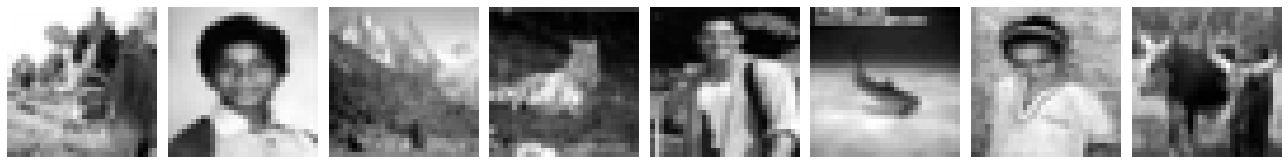

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(18,8))
for i in range(8):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

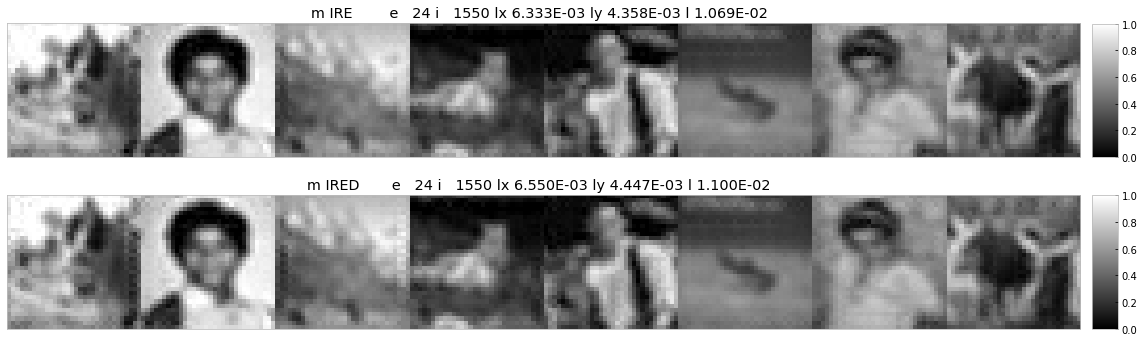

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _ in loader:
        y = split(blur(x)[:,0,:,:]).to(device).detach()
        x = split(x[:,0,:,:]).to(device)
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()

#             # Validation
#             with torch.no_grad():
#                 yth = nets[cur](xt)
#                 xth = nets[cur].T(yt)
#                 ldicts[cur]['lt'] = utils.loss.logcosh(xth, xt, alpha=4, reduction='mean')
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    xhs[cur] = split.T(nets[cur].T(ys)).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, cmap='gray')
            
        i += 1

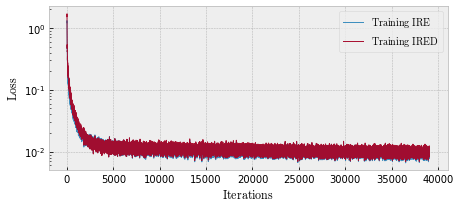

In [11]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

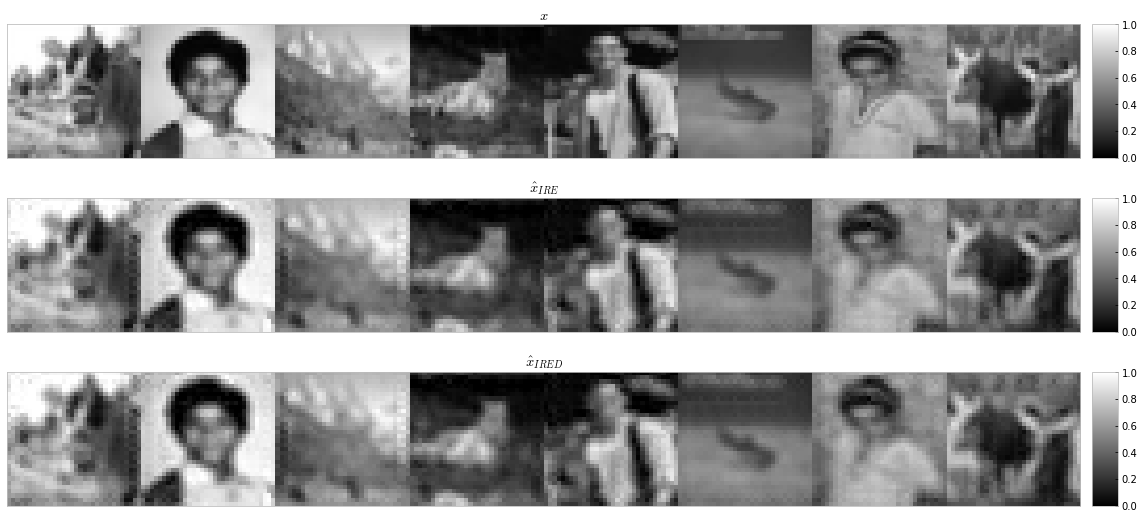

In [12]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(ys)).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

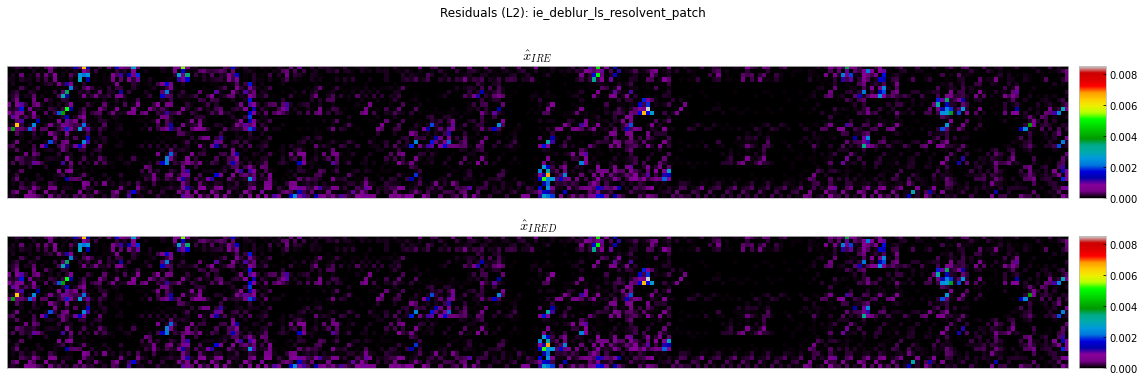

In [13]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(nets[cur](xs))).cpu()
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [14]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [15]:
# Compute test tensor
test_tensor = xt.cpu()

In [16]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        re_x = utils.metrics.relative_error(XH, xt.cpu(), reduction='mean')
        re_y = utils.metrics.relative_error(YH, yt.cpu(), reduction='mean')
        mse_x = F.mse_loss(XH, xt.cpu(), reduction='mean')
        mse_y = F.mse_loss(YH, yt.cpu(), reduction='mean')
    print(
        f"{k:6}: " + 
        f"REx {re_x:4E} " +
        f"REy {re_y:4E} " +
        f"RE  {(re_x + re_y) / 2:4E} " +
        f"MSEx {mse_x:4E} " + 
        f"MSEy {mse_y:4E} " +
        f"MSE  {(mse_x + mse_y) / 2:4E} "
    )

Relative Error:
IRE   : REx 1.034386E-01 REy 8.592708E-02 RE  9.468283E-02 MSEx 2.053645E-03 MSEy 1.379098E-03 MSE  1.716372E-03 
IRED  : REx 1.070194E-01 REy 8.611474E-02 RE  9.656709E-02 MSEx 2.201273E-03 MSEy 1.431395E-03 MSE  1.816334E-03 


In [17]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        psnr_x = utils.metrics.psnr(xt.cpu(), XH)
        ssim_x = utils.metrics.ssim(
            split.T(xt.cpu())[:,None,...], 
            split.T(XH)[:,None,...]
        )
        psnr_y = utils.metrics.psnr(yt.cpu(), YH)
        ssim_y = utils.metrics.ssim(
            split.T(yt.cpu())[:,None,...], 
            split.T(YH)[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNRx: {psnr_x:4E} " +
        f"PSNRy: {psnr_y:4E} " +
        f"PSNR:  {(psnr_y + psnr_x) / 2:4E} " +
        f"SSIMx: {ssim_x:4E} " +
        f"SSIMy: {ssim_y:4E} " +
        f"SSIM:  {(ssim_y + ssim_x) / 2:4E} "
    )

Image Reconstruction Metrics:
IRE   : PSNRx: 2.687475E+01 PSNRy: 2.860405E+01 PSNR:  2.773940E+01 SSIMx: 9.255524E-01 SSIMy: 9.461118E-01 SSIM:  9.358321E-01 
IRED  : PSNRx: 2.657326E+01 PSNRy: 2.844241E+01 PSNR:  2.750783E+01 SSIMx: 9.218767E-01 SSIMy: 9.449666E-01 SSIM:  9.334216E-01 


In [18]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(64, 16).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [19]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

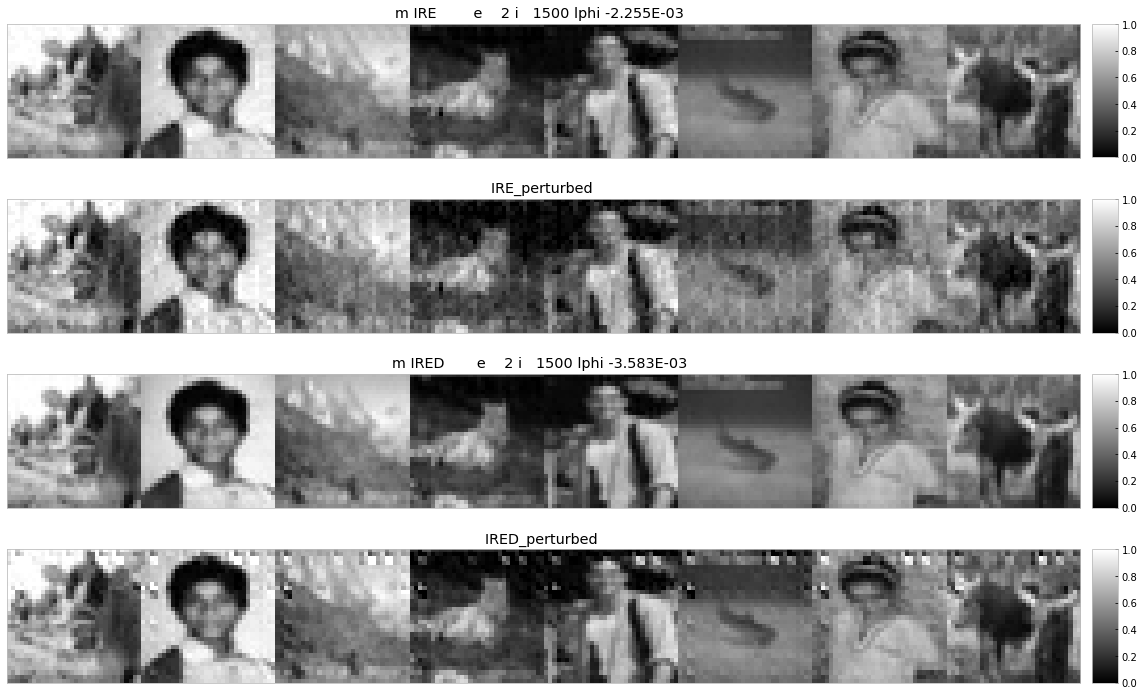

In [20]:
# Training loop

for e in range(3):
    i = 0
    for x, _ in loader:
        y = split(blur(x)[:,0,:,:]).to(device).detach()
        x = split(x[:,0,:,:]).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (64, 16))

            xh = nets[cur].T(nets[cur](x))
            xe = nets[cur].T(nets[cur](x + r))

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = split.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split.T(nets[cur].T(nets[cur](xs + r))).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

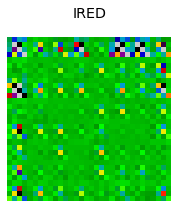

In [21]:
fig, ax = plt.subplots(1)
for i, (k, r) in enumerate(rs.items()):
    ax.matshow(
        split.T(r[None,...])[0].cpu().detach(), 
        vmin=-1, 
        vmax=1
    )
    ax.grid(False)
    ax.axis('off')
    ax.set_title(k)

plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [22]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
        XE = model.T(model(test_tensor + r))

    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + rs[k].cpu(), XE, reduction='mean')}")

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(
        split.T(XH).flatten(-2, -1), 
        split.T(XE).flatten(-2, -1),
        split.T(test_tensor).flatten(-2, -1),
        split.T(r[None,...])[0].flatten(-2, -1),
        reduction='mean'
    )
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
IRE   : 0.7373806834220886
IRED  : 0.3004550039768219
Relative Cond:
IRE   : 0.145276 0.106000 5.324584
IRED  : 0.119856 0.069521 6.654010


In [23]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [24]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [25]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

In [26]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(64, 16).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [27]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

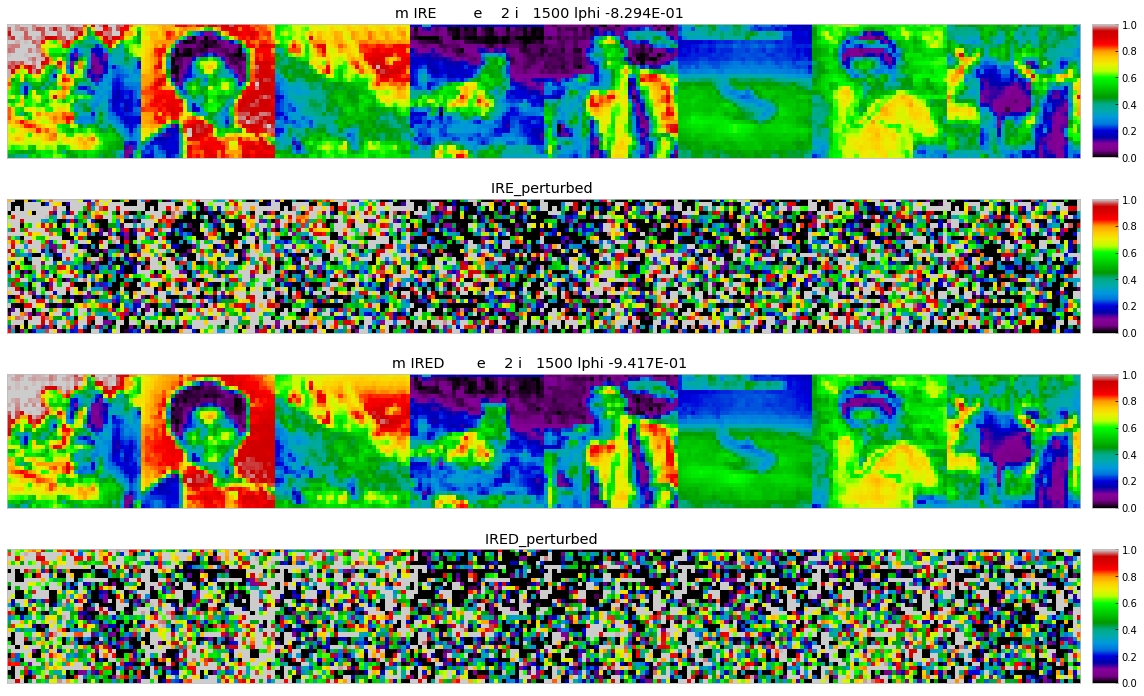

In [28]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        y = split(blur(x)[:,0,:,:]).to(device).detach()
        x = split(x[:,0,:,:]).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)
                    xhs[cur] = split.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split.T(nets[cur].T(nets[cur](xs) + r)).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [29]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    YE = model.T(yt.cpu() + r)
    YH = model.T(yt.cpu())

    cond_no = utils.metrics.relative_cond_no(YH, YE, yt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
IRE   : 122.439354
IRED  : 125.209068
